In [1]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA

# Data Import and Cleaning

In [2]:
%store -r df_cleaned
df = df_cleaned 

In [3]:
TS1 = df[(df['Plz'] == "['25', '24']")]
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

# Modelling - Train, test split

In [4]:
splitratio = 0.05
nobs = round(len(TS1_A1A2)*splitratio)
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

In [5]:
# df_train

## Prophet

In [6]:
import prophet

In [7]:
from prophet import Prophet

Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
- Datetime column named: ds
- target : y

In [8]:
#pjme_train_prophet = df_train.reset_index() 
pjme_train_prophet = df_train.rename(columns={'date':'ds',
                     'wPreis':'y'})
pjme_train_prophet = pjme_train_prophet[['ds', 'y']]

In [9]:
model = Prophet()

Prophet does a static prediction by default. 
There does not seem to be an option to do a rolling window as the model simply outputs the predictions for the number of steps specified after taking in a set input.

So that leaves only walk-forward validation as the only option to compare.
In this, we can train the prophet model to predict just one step ahead and retrain at every step using the appended new observation. 

## Static Forecasting
For the first approach, we fit the model to the entire training dataset once.

In [10]:
model.fit(pjme_train_prophet)

12:20:43 - cmdstanpy - INFO - Chain [1] start processing


12:20:43 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
#pjme_train_prophet = df_train.reset_index() 
pjme_test_prophet = df_test.rename(columns={'date':'ds',
                     'wPreis':'y'})

pjme_test_prophet = pjme_test_prophet[['ds', 'y']]

The recommended approach with Prophet is to create a new dataframe using "make_future_dataframe" method with the number of periods specified (which we will specify as 6, for getting the predictions to compare with the length of the test data set).
To get the exact dates matching with that of the test data set, I had to specify the frequency as weekly, with a start of Monday.

In [12]:
future = model.make_future_dataframe(periods=nobs, freq='W-MON')


In [13]:
pjme_test_fcst_future = model.predict(future)


In [14]:
future_yhat = pjme_test_fcst_future['yhat'].iloc[-nobs:]


Predicting on the newly created dataframe outputs a standard Prophet dataframe with various metrics for the prediction. The important one is yhat, which is the actual prediction value for the period steps.

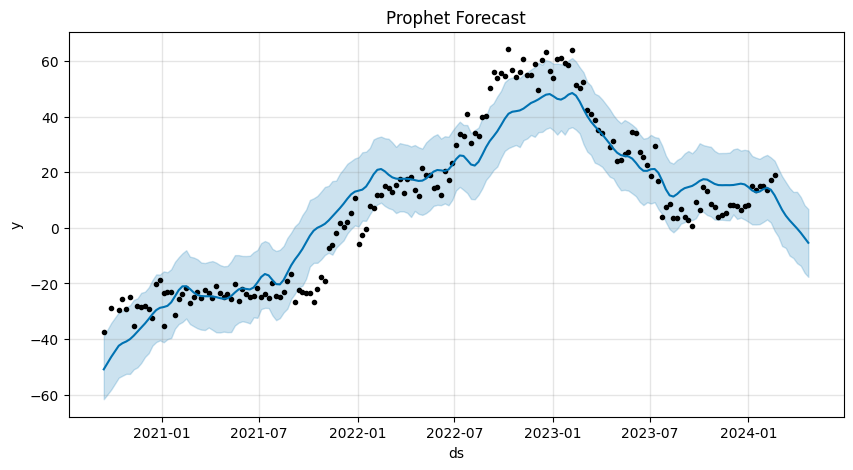

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst_future, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

In [16]:
def forecast_accuracy(forecast, actual):
      mae = mean_absolute_error(actual, forecast)
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'mae': mae,'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [17]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print(f'Forecast Accuracy (Prophet static) for {df_test["full"].iloc[0]} in {df_test["Plz"].iloc[0]}')
stat_accuracy_prod = forecast_accuracy(pjme_test_fcst_future['yhat'].iloc[-nobs:].values, df_test['wPreis'])
print('MAE: %.3f' % stat_accuracy_prod['mae'])
print('ME: %.3f' % stat_accuracy_prod['me'])
print('RMSE: %.3f' % stat_accuracy_prod['rmse'])
print('Direction Accuracy: %.3f' % stat_accuracy_prod['direction_accuracy'])

Forecast Accuracy (Prophet static) for A1 & A2 -  geschreddert in ['25', '24']
MAE: 8.468
ME: -8.006
RMSE: 10.414
Direction Accuracy: 0.500


In [18]:
future_yhat.index = df_test['wPreis'].index

In [48]:
future_yhat

date
2024-02-26    9.090320
2024-03-04    6.505521
2024-03-11    4.395738
2024-03-18    2.724394
2024-03-25    1.256270
2024-04-01   -0.214485
2024-04-08   -1.808153
2024-04-15   -3.562815
2024-04-22   -5.370127
Name: yhat, dtype: float64

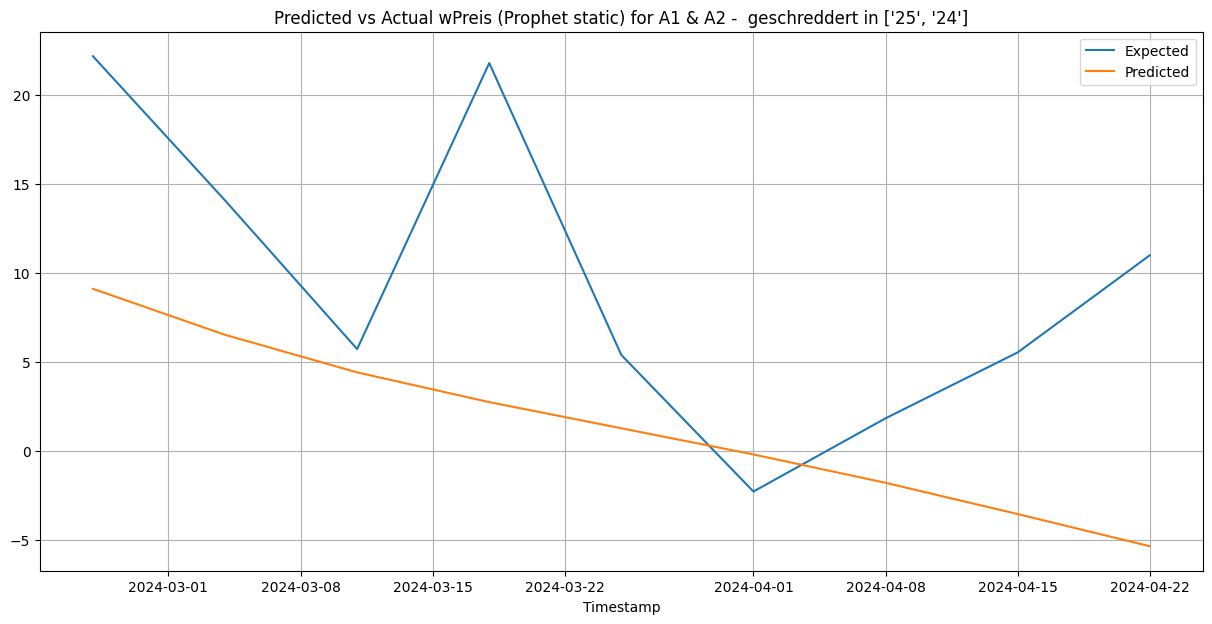

In [19]:
# plot expected vs preducted

plt.figure(figsize=(15, 7))
plt.xlabel("Timestamp")
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(future_yhat, label='Predicted')
plt.title(f'Predicted vs Actual wPreis (Prophet static) for {df_test["full"].iloc[0]} in {df_test["Plz"].iloc[0]}')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
Prophet_static = pd.DataFrame([stat_accuracy_prod])
Prophet_static



,mae,me,rmse,direction_accuracy
0,8.468395,-8.00553,10.4144,0.5


In [21]:
%store Prophet_static


Stored 'Prophet_static' (DataFrame)


In [22]:
future_yhat.index = df_test.index


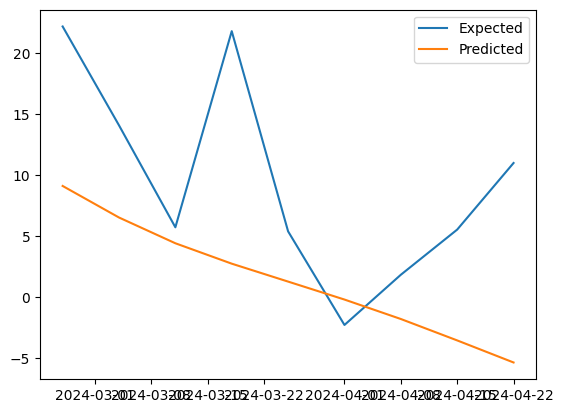

In [23]:
# plot expected vs preducted
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(future_yhat, label='Predicted')
plt.legend()
plt.show()

## Walk-forward validation

For walk-forward validation, just as before we train the model at every step of a loop where we append the training dataset with the newest step from the test data set and predict corresponding one-step at each stage to get a prediction list.

In [24]:
predictions = {}

In [25]:
input = pjme_train_prophet #starting input as the original training dataset
for t in range(0,len(pjme_test_prophet)):
    model = Prophet() #Prophet requires an initialisation every time before fit
    model.fit(input) 
    future = model.make_future_dataframe(periods=1, freq='W-MON') # we only make the future dataframe for 1 step at a time now
    pred_step = model.predict(future) # and get the prediction "row" for that one step
    # print(pred_step.iloc[-1:]['yhat']) 
    predictions = pred_step[-1:]['yhat'] # adding the yhat value of the last, newest row in the predicted dataframe 
    new_obs = pjme_test_prophet.iloc[t] # getting the next row from the test dataframe
    # print(new_obs['y']) 
    input = input.append(new_obs, ignore_index=True) # appending the new row from the test dataframe to the input at every step


12:20:44 - cmdstanpy - INFO - Chain [1] start processing
12:20:44 - cmdstanpy - INFO - Chain [1] done processing
12:20:44 - cmdstanpy - INFO - Chain [1] start processing
12:20:44 - cmdstanpy - INFO - Chain [1] done processing
12:20:44 - cmdstanpy - INFO - Chain [1] start processing
12:20:44 - cmdstanpy - INFO - Chain [1] done processing
12:20:44 - cmdstanpy - INFO - Chain [1] start processing
12:20:44 - cmdstanpy - INFO - Chain [1] done processing
12:20:44 - cmdstanpy - INFO - Chain [1] start processing
12:20:44 - cmdstanpy - INFO - Chain [1] done processing
12:20:44 - cmdstanpy - INFO - Chain [1] start processing
12:20:44 - cmdstanpy - INFO - Chain [1] done processing
12:20:45 - cmdstanpy - INFO - Chain [1] start processing
12:20:45 - cmdstanpy - INFO - Chain [1] done processing
12:20:45 - cmdstanpy - INFO - Chain [1] start processing
12:20:45 - cmdstanpy - INFO - Chain [1] done processing
12:20:45 - cmdstanpy - INFO - Chain [1] start processing
12:20:45 - cmdstanpy - INFO - Chain [1]

In [26]:
# pred_step.head(15)

In [27]:
predictions = pred_step[-nobs:]['yhat']

In [28]:
predictions.index = pjme_test_prophet.index
# predictions

In [29]:
# pjme_test_prophet

In [32]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Prophet Forecast Accuracy of: wPreis')
wf_accuracy_prod = forecast_accuracy(predictions, pjme_test_prophet['y'])

mae = wf_accuracy_prod['mae']
me = wf_accuracy_prod['me']
rmse = wf_accuracy_prod['rmse']
# expected = wf_accuracy_prod['expected']
# predictions = wf_accuracy_prod['predictions']
direction_accuracy = wf_accuracy_prod['direction_accuracy']

print(f'Forecast Accuracy (Prophet Walk-forward) for {df_test["full"].iloc[0]} in {df_test["Plz"].iloc[0]}')
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)

Prophet Forecast Accuracy of: wPreis
Forecast Accuracy (Prophet Walk-forward) for A1 & A2 -  geschreddert in ['25', '24']
MAE: 6.264
ME: -4.487
RMSE: 7.939
Direction Accuracy: 0.500


In [33]:
Prophet_wf = pd.DataFrame([wf_accuracy_prod])
Prophet_wf



,mae,me,rmse,direction_accuracy
0,6.264178,-4.487235,7.939459,0.5


In [34]:
%store Prophet_wf 

Stored 'Prophet_wf' (DataFrame)


In [49]:
predictions

date
2024-02-26    12.588029
2024-03-04    10.759438
2024-03-11     8.825628
2024-03-18     6.667150
2024-03-25     4.464712
2024-04-01     2.577434
2024-04-08     1.096667
2024-04-15    -0.309396
2024-04-22    -1.988348
Name: yhat, dtype: float64

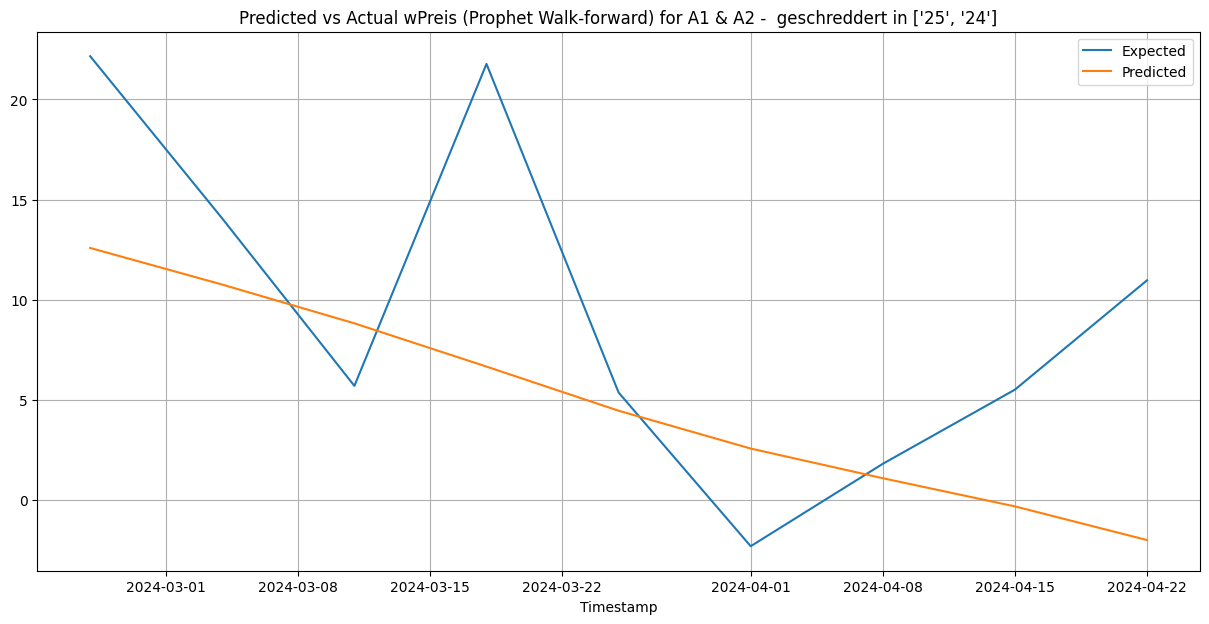

In [35]:
# # plot expected vs preducted
# plt.plot(pjme_test_prophet['y'], label='Expected')
# plt.plot(predictions, label='Predicted')
# plt.legend()
# plt.show()


plt.figure(figsize=(15, 7))
plt.xlabel("Timestamp")
plt.plot(pjme_test_prophet['y'], label='Expected')
plt.plot(predictions, label='Predicted')
plt.title(f'Predicted vs Actual wPreis (Prophet Walk-forward) for {df_test["full"].iloc[0]} in {df_test["Plz"].iloc[0]}')
plt.legend()
plt.grid(True)
plt.show()

## All other clusters and categories 

In [36]:
def static_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    df_train, df_test = data[0:-nobs], data[-nobs:]
    pjme_train_prophet = df_train.rename(columns={'date':'ds',
                     'wPreis':'y'})
    pjme_train_prophet = pjme_train_prophet[['ds', 'y']]


    model = Prophet()
    model.fit(pjme_train_prophet)

    pjme_test_prophet = df_test.rename(columns={'date':'ds',
                     'wPreis':'y'})
    pjme_test_prophet = pjme_test_prophet[['ds', 'y']]

    future = model.make_future_dataframe(periods=nobs, freq='W-MON')
    pjme_test_fcst_future = model.predict(future)

    stat_accuracy_prod = forecast_accuracy(pjme_test_fcst_future['yhat'].iloc[-nobs:].values, pjme_test_prophet['y'])
    return stat_accuracy_prod


In [37]:
def wf_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    df_train, df_test = data[0:-nobs], data[-nobs:]
    pjme_train_prophet = df_train.rename(columns={'date':'ds',
                     'wPreis':'y'})
    pjme_train_prophet = pjme_train_prophet[['ds', 'y']]

    pjme_test_prophet = df_test.rename(columns={'date':'ds',
                     'wPreis':'y'})
    pjme_test_prophet = pjme_test_prophet[['ds', 'y']]

    input = pjme_train_prophet #starting input as the original training dataset
    for t in range(0,len(pjme_test_prophet)):
        model = Prophet() #Prophet requires an initialisation every time before fit
        model.fit(input) 
        future = model.make_future_dataframe(periods=1, freq='W-MON') # we only make the future dataframe for 1 step at a time now
        pred_step = model.predict(future) # and get the prediction "row" for that one step
        # print(pred_step.iloc[-1:]['yhat']) 
        predictions = pred_step[-1:]['yhat'] # adding the yhat value of the last, newest row in the predicted dataframe 
        new_obs = pjme_test_prophet.iloc[t] # getting the next row from the test dataframe
        # print(new_obs['y']) 
        input = input.append(new_obs, ignore_index=True) # appending the new row from the test dataframe to the input at every step

    prediction_wf = pred_step[-nobs:]['yhat']
    prediction_wf.index = pjme_test_prophet.index

    wf_accuracy_prod = forecast_accuracy(prediction_wf, pjme_test_prophet['y'])
    return wf_accuracy_prod

In [38]:
clusters = df['Plz'].unique() 
datasets = []
for cluster in clusters:
    ds = df[(df['Plz'] == cluster)]
    categories = ds['full'].unique()
    for category in categories:
        datasets.append(ds[ds['full'] == category])

In [39]:
import warnings

# Filter out the specific warning
warnings.filterwarnings('ignore')
data = []
# Loop through each category
for dataset in datasets:
    static_forecast(dataset)
    wf_forecast(dataset)
    static_results = static_forecast(dataset)
    wf_results = wf_forecast(dataset)
    
    # Create a dictionary to store the results
    results_dict = {
        'Cluster': dataset['Plz'].iloc[0],   
        'Category': dataset['full'].iloc[0],   
        'Prophet_static_mae': static_results['mae'],
        'Prophet_static_me': static_results['me'],
        'Prophet_static_rmse': static_results['rmse'],
        'Prophet_static_direction_accuracy': static_results['direction_accuracy'],
        'Prophet_wf_mae': wf_results['mae'],
        'Prophet_wf_me': wf_results['me'],
        'Prophet_wf_rmse': wf_results['rmse'],
        'Prophet_wf_direction_accuracy': wf_results['direction_accuracy']
    }
    
    # Append the dictionary to the list
    data.append(results_dict)

# Create a DataFrame from the list of dictionaries
df_results = pd.DataFrame(data)

# Print the DataFrame
# df_results

12:22:12 - cmdstanpy - INFO - Chain [1] start processing
12:22:12 - cmdstanpy - INFO - Chain [1] done processing
12:22:12 - cmdstanpy - INFO - Chain [1] start processing
12:22:12 - cmdstanpy - INFO - Chain [1] done processing
12:22:13 - cmdstanpy - INFO - Chain [1] start processing
12:22:13 - cmdstanpy - INFO - Chain [1] done processing
12:22:13 - cmdstanpy - INFO - Chain [1] start processing
12:22:13 - cmdstanpy - INFO - Chain [1] done processing
12:22:13 - cmdstanpy - INFO - Chain [1] start processing
12:22:13 - cmdstanpy - INFO - Chain [1] done processing
12:22:13 - cmdstanpy - INFO - Chain [1] start processing
12:22:13 - cmdstanpy - INFO - Chain [1] done processing
12:22:13 - cmdstanpy - INFO - Chain [1] start processing
12:22:13 - cmdstanpy - INFO - Chain [1] done processing
12:22:13 - cmdstanpy - INFO - Chain [1] start processing
12:22:13 - cmdstanpy - INFO - Chain [1] done processing
12:22:13 - cmdstanpy - INFO - Chain [1] start processing
12:22:13 - cmdstanpy - INFO - Chain [1]

In [ ]:
ProphetResults = df_results
%store ProphetResults

In [40]:
df_results.to_csv('Prophet_Results.csv')

In [50]:
df_metrics = df_results[['Cluster', 'Category', 'Prophet_static_rmse', 'Prophet_wf_rmse', 'Prophet_static_direction_accuracy', 'Prophet_wf_direction_accuracy']]

In [57]:
def getRMSEplot(df_plot):
    # Create subplots
    fig, ax = plt.subplots()

    # Define bar width
    bar_width = 0.35

    # Define the positions for the bars
    clusters = df_plot['Cluster']
    static_rmse = df_plot['Prophet_static_rmse']
    wf_rmse = df_plot['Prophet_wf_rmse']
    ind = range(len(clusters))

    # Plot the bars
    ax.barh(ind, static_rmse, bar_width, label='Static RMSE')
    ax.barh([x + bar_width for x in ind], wf_rmse, bar_width, label='Walk-forward RMSE')

    # Add RMSE values next to each bar
    for i, (s_rmse, wf_rmse) in enumerate(zip(static_rmse, wf_rmse)):
        ax.text(s_rmse, i, f'{s_rmse:.2f}', ha='right', va='center')
        ax.text(wf_rmse, i + bar_width, f'{wf_rmse:.2f}', ha='right', va='center')

    # Set labels and title
    ax.set_xlabel('RMSE')
    ax.set_ylabel('Cluster')
    ax.set_title(f'RMSE comparison of Static and Walk-forward Prophet across clusters for {df_plot["Category"].iloc[0]}')


    # Set yticks and labels
    ax.set_yticks(ind)
    ax.set_yticklabels(df_plot['Cluster'])

    # Move legend outside the graph
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))   # Add legend

    # Show plot
    plt.show()

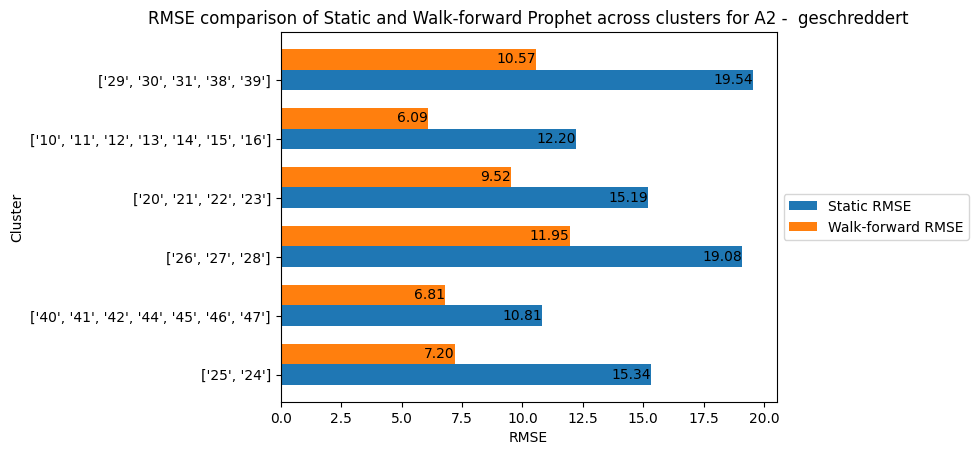

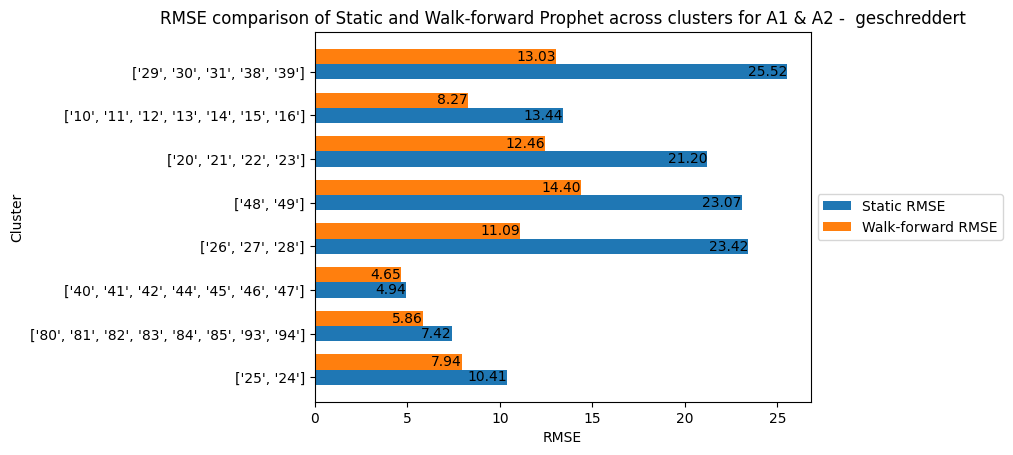

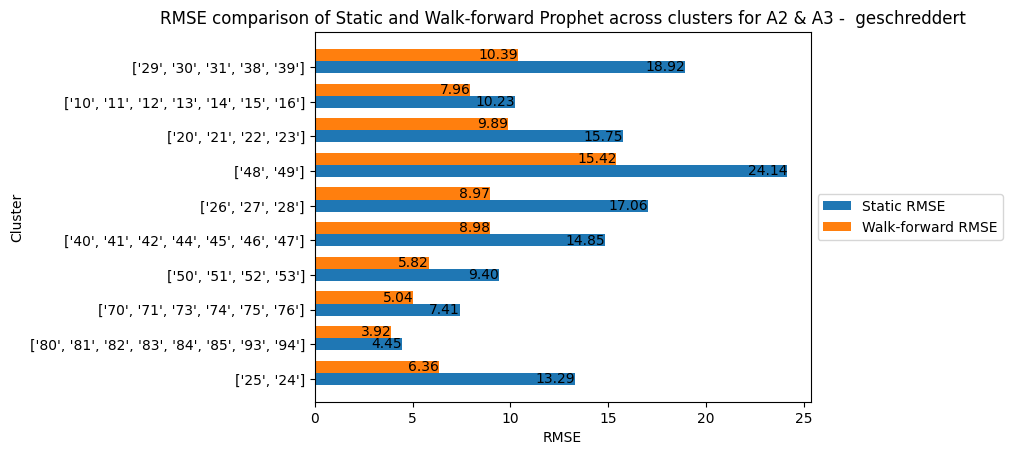

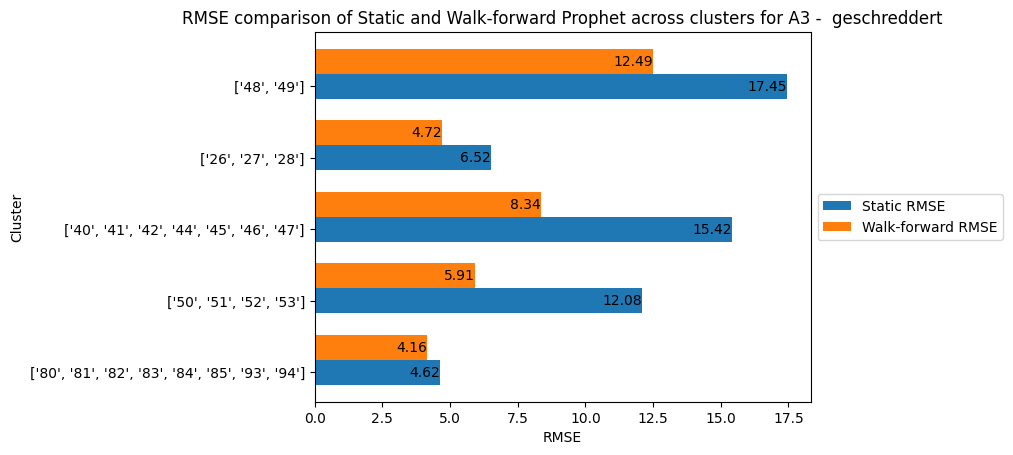

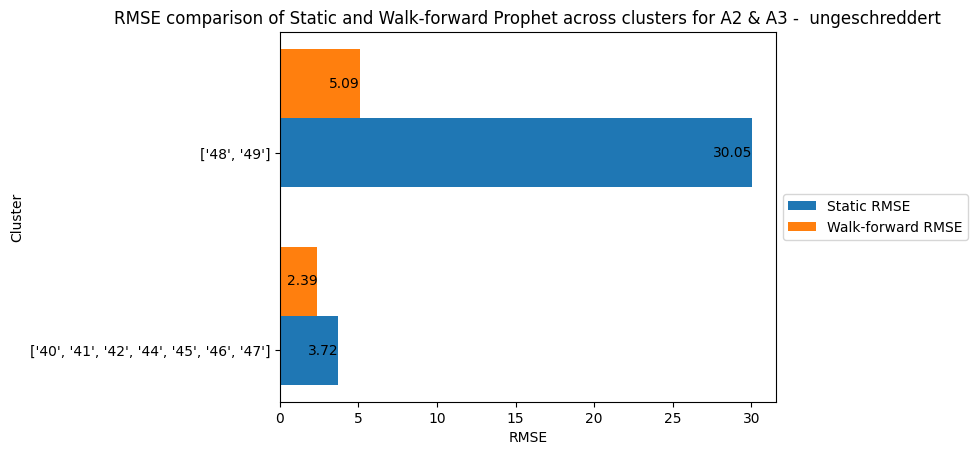

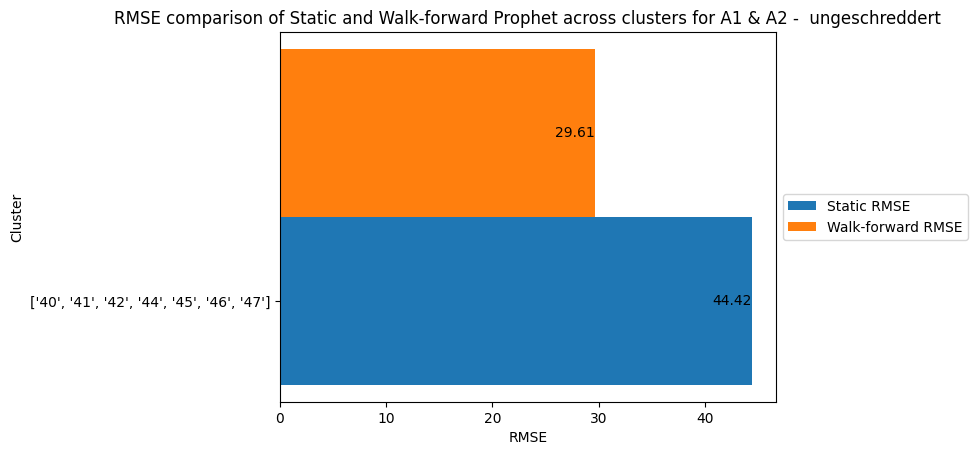

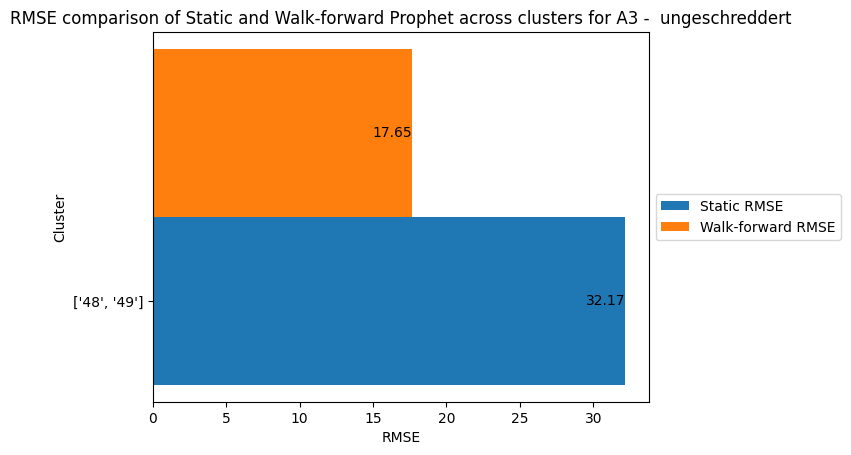

In [58]:
for category in df_metrics['Category'].unique():
    filtered = df_metrics[df_metrics['Category'] == category]
    getRMSEplot(filtered)

In [59]:
def getDirAccplot(df_plot):
    # Create subplots
    fig, ax = plt.subplots()

    # Define bar width
    bar_width = 0.35

    # Define the positions for the bars
    clusters = df_plot['Cluster']
    static_direction_acc = df_plot['Prophet_static_direction_accuracy']
    wf_direction_acc = df_plot['Prophet_wf_direction_accuracy']
    ind = range(len(clusters))

    # Plot the bars
    ax.barh(ind, static_direction_acc, bar_width, label='Static Direction Accuracy')
    ax.barh([x + bar_width for x in ind], wf_direction_acc, bar_width, label='Walk-forward Direction Accuracy')

    # Add direction accuracy values next to each bar
    for i, (s_dir_acc, wf_dir_acc) in enumerate(zip(static_direction_acc, wf_direction_acc)):
        ax.text(s_dir_acc, i, f'{s_dir_acc:.2f}', ha='right', va='center')
        ax.text(wf_dir_acc, i + bar_width, f'{wf_dir_acc:.2f}', ha='right', va='center')

    # Set labels and title
    ax.set_xlabel('Direction Accuracy')
    ax.set_ylabel('Cluster')
    ax.set_title(f'Direction accuracy comparison of Static and Walk-forward Prophet across clusters for {df_plot["Category"].iloc[0]}')

    # Set yticks and labels
    ax.set_yticks(ind)
    ax.set_yticklabels(df_plot['Cluster'])

    # Move legend outside the graph
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))   # Add legend

    # Show plot
    plt.show()

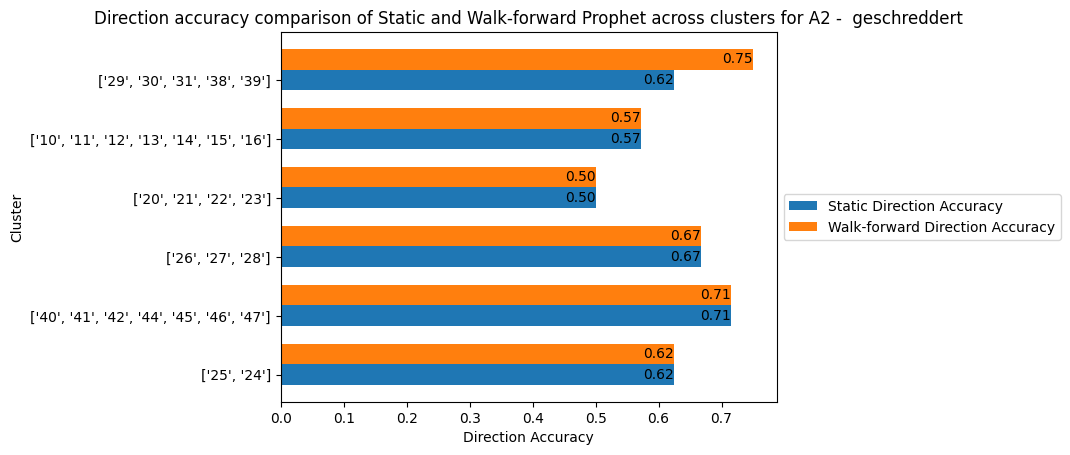

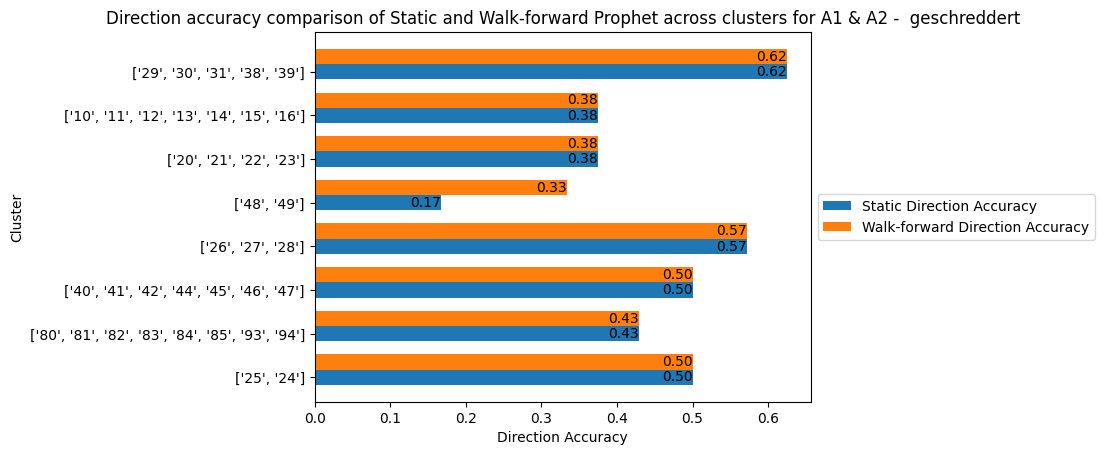

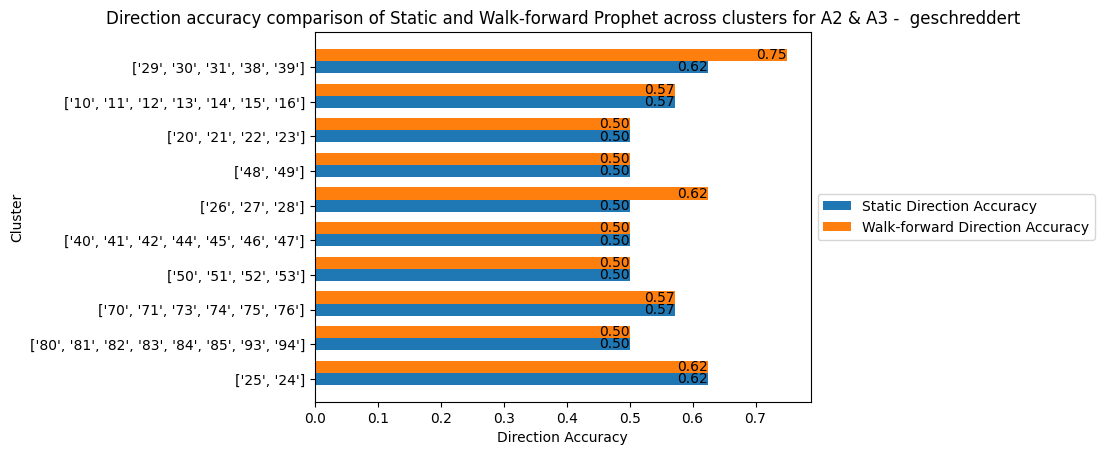

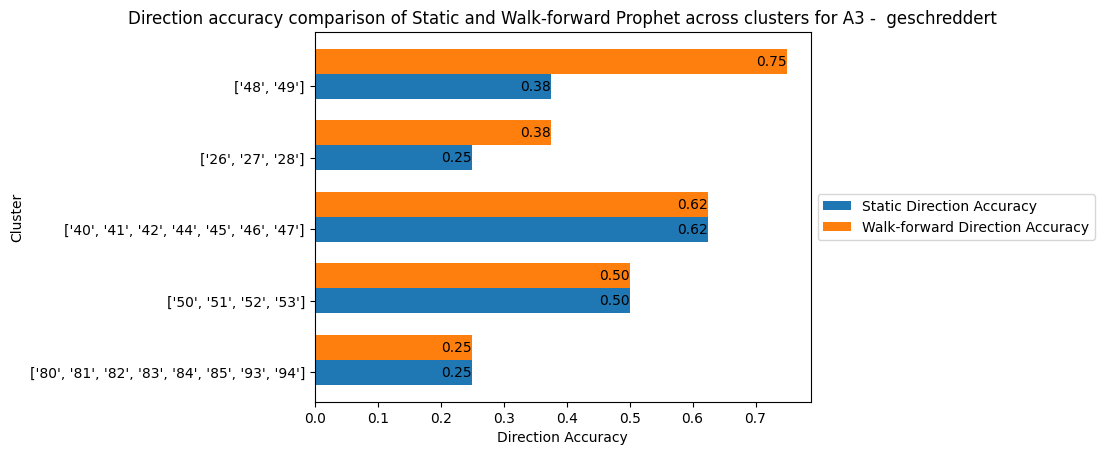

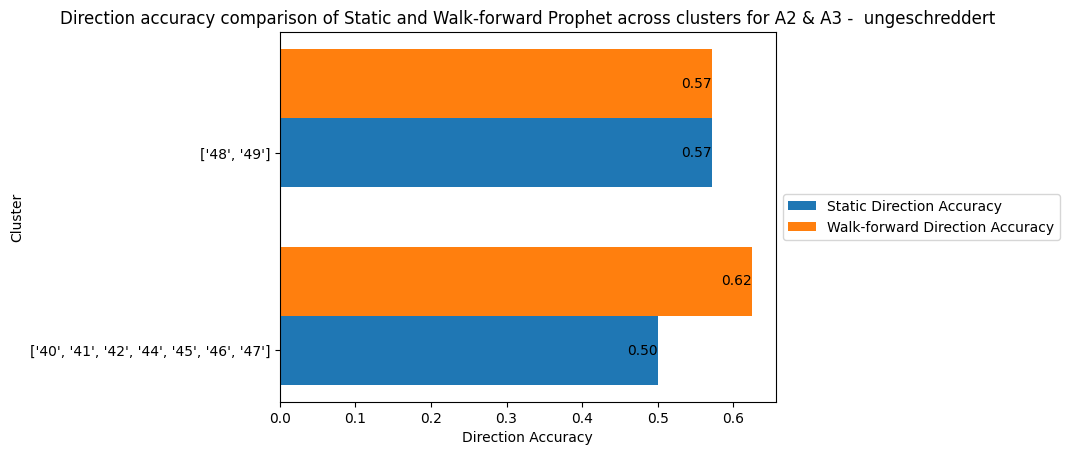

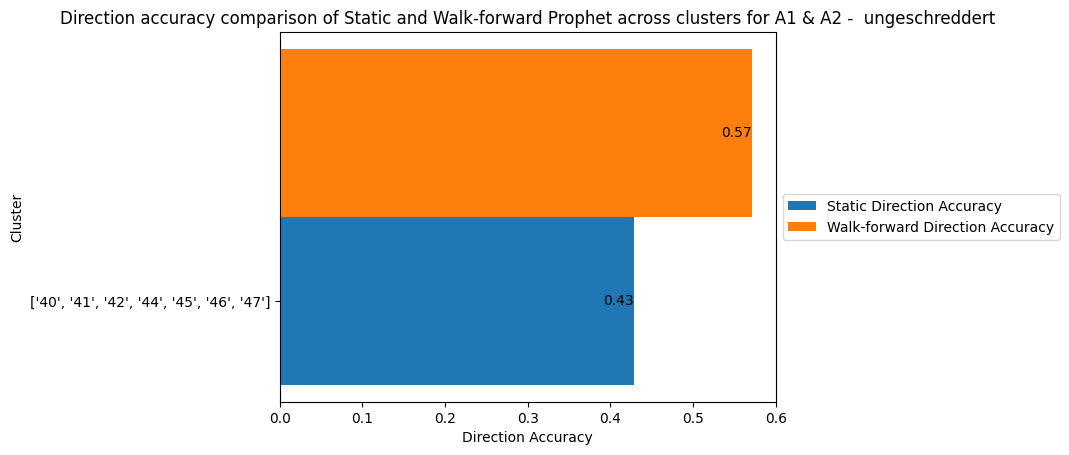

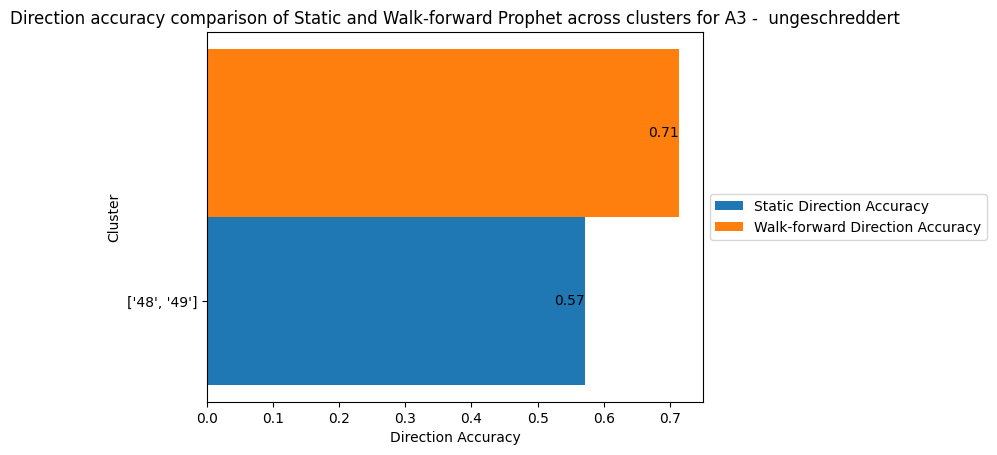

In [60]:
for category in df_metrics['Category'].unique():
    filtered = df_metrics[df_metrics['Category'] == category]
    getDirAccplot(filtered)

PLOTLY GRAPHS FOR THE SAME

In [61]:
# def getRMSEplot(df_plot):
#     traces = []
#     for metric in ['Prophet_static_rmse', 'Prophet_wf_rmse']:
#         trace = go.Bar(
#             x= df_plot[metric],
#             y= df_plot['Cluster'], 
#             name=metric,
#             orientation='h'
#         )
#         traces.append(trace)

#     # Define layout
#     layout = go.Layout(
#         title= f'Comparison of Prophet RMSE for Static and Walk-forward Validation across Clusters for {df_plot["Category"].iloc[0]}',
#         xaxis=dict(title='RMSE'),
#         yaxis=dict(title='Cluster'),
#         barmode='group'
#     )

#     # Create figure
#     fig = go.Figure(data=traces, layout=layout)

#     # Show figure
#     fig.show()


In [62]:
# def getDirAccplot(df_plot):
#     traces = []
#     for metric in ['Prophet_static_direction_accuracy', 'Prophet_wf_direction_accuracy']:
#         trace = go.Bar(
#             x= df_plot[metric],
#             y= df_plot['Cluster'], 
#             name=metric,
#             orientation='h'
#         )
#         traces.append(trace)

#     # Define layout
#     layout = go.Layout(
#         title= f'Comparison of Direction Accuracy using Prophet between Static and Walk-Forward across Clusters for {df_plot["Category"].iloc[0]}',
#         xaxis=dict(title='Direction Accuracy'),
#         yaxis=dict(title='Cluster'),
#         barmode='group'
#     )

#     # Create figure
#     fig = go.Figure(data=traces, layout=layout)

#     # Show figure
#     fig.show()
# for category in df_metrics['Category'].unique():
#     filtered = df_metrics[df_metrics['Category'] == category]
#     getRMSEplot(filtered)
#     getDirAccplot(filtered)
